# Tutorial 5: Query metadata & pipeline outputs in Athena to accelerate analysis

Once Athena is enabled, the world (or data in this case...) is the Computational Biologist's oyster! Computational biologists can now use the Athena to make SQL queries to obtain desired subsets of data to empower their analysis quickly and efficiently. Queries can be performed directly in Jupyter notebooks, enabling seamless data loading upstream of analysis.

In contrast, without Athena capabilities, comp bio folks would have figure out which samples they want by loading a master metadata table somewhere, perform some detective work to track down where the output tables of their desired samples live, and load those files 1-by-1.

Additionally, Athena tables are compatible with interactive dashboards (e.g. Tableau, Spotfire, QuickSight), allowing you to keep track of the number of samples, which samples, or other accounting metrics that may be helpful beyond computational teams (business development, project management) in a "no-code" manner.

In this tutorial, we will use the Athena tables & views generated from sample-level metadata & primary pipeline outputs from Nextflow data packages generated with the `nf-quilt` plugin to enable biological discovery & analysis. 

In [1]:
import sqlalchemy
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Connect to Athena

In [2]:
# user to fill in AWS credentials (or auth in preferred method)
aws_access_key_id = "USER_ACCESS KEY"
aws_secret_access_key = "USER SECRET ACCESS KEY"
region_name = "us-east-1"
bucket_name = "s3://quilt-example-bucket/ccle"

In [ ]:
# connect to Athena
conn = connect(aws_access_key_id=aws_access_key_id,
               aws_secret_access_key=aws_secret_access_key,
               region_name=region_name,
               s3_staging_dir= bucket_name)

# 2. Example Scenario: Selecting EGFR-high cell lines for pre-clinical testing

- Imagine your biotech has developed a new generation of EGFR inhibitor  
- This inhibitor is hypothesized to improve outcomes in cancer patients with high expression of the target gene, EGFR. 
- Your company has sequenced a cohort of cancer cell lines in attempt to identify a subset of EGFR-high expressing model cell lines.
- Idenitfying "EGFR-high" cancer cell lines is crucial for selecting the correct cell lines to use in preclinical lab experiments, as they best mirror biology of EGFR-high tumors in the clinic.

## 2.1 Which cell line lineages have the highest EGFR transcript expression?

- First off, we want to know which types (lineages) of cancer have cell lines that express EGFR highly

- By joining sample-level metadata (lineage information), to pipeline outputs (expression) matrices, we can easily compare EGFR expression across cell lines of different cancer lineages
- Interstingly, liver cells lines are amongst the highest EGFR expressing indications
- Understanding which cancer types, and corresponding cell lines, highly express a target (EGFR) of interest helps ensure the correct models are used in pre-clinical experiments and increase chances of biology observed in the lab translating to the clinic

In [12]:
# RefSeq ID for EGFR transcript of interest is NM_004985

In [55]:
# define query of interest
query_1 = """
SELECT
    expression.*,
    metadata.*
FROM
    "userathenadatabase-2htmlbiqyvry"."ccle_nfcore_rnaseq_datalake" AS expression
JOIN
    "userathenadatabase-2htmlbiqyvry"."ccle_raw_data_pkg_metadata" AS metadata
ON
    expression.sample_id = metadata.run
WHERE
    expression.name LIKE 'NM_201284%'
"""

# execute the query
cursor = conn.cursor()
cursor.execute(query_1)

# fetch the results
egfr_expression = pd.read_sql(query_1, conn)
egfr_expression.head()

/var/folders/np/3pjq4pjd4gj2x_kjmxbt2wxc0000gn/T/ipykernel_87390/1304740185.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  egfr_expression = pd.read_sql(query_1, conn)


,name,length,effectivelength,tpm,numreads,run_id,sample_id,pkg_name,top_hash,timestamp,...,patientid,sex,celllinesource,librarysource,libraryselection,bioproject,libraryname,sampletype,mutationcount,age
0,NM_201284.1,2865,2627.219,0.000000,0.000,20190225_PRJNA523380_nfcore_rnaseq,SRR8618316,ccle/20190225_PRJNA523380_SRR8618316,fd5b754de3883726f70ba0c60cef0d58cda93223b5d980...,latest,...,WM1799_SKIN,Unknown,WISTAR,TRANSCRIPTOMIC,cDNA,PRJNA523380,RNASeq-WM1799_SKIN,cell culture,349.0,None
1,NM_201284.1,2865,2643.287,0.487383,5.905,20190225_PRJNA523380_nfcore_rnaseq,SRR8618309,ccle/20190225_PRJNA523380_SRR8618309,462d12730869d2d14d6c9468b0ea0b887623fe542b5b62...,latest,...,YD10B_UPPER_AERODIGESTIVE_TRACT,male,KCLB,TRANSCRIPTOMIC,cDNA,PRJNA523380,RNASeq-YD10B_UPPER_AERODIGESTIVE_TRACT,cell culture,323.0,67.0
2,NM_201284.1,2865,2638.196,0.175977,13.426,20190224_PRJNA523380_nfcore_rnaseq,SRR8615906,ccle/20190224_PRJNA523380_SRR8615906,87c5c3af65597a0d4c6b1a8a8607f5e4029495a7a43e6f...,latest,...,KM12_LARGE_INTESTINE,Unknown,NIBRI,TRANSCRIPTOMIC,cDNA,PRJNA523380,RNASeq-KM12_LARGE_INTESTINE,cell culture,3296.0,None
3,NM_201284.1,2865,2591.898,0.016812,1.567,20190225_PRJNA523380_nfcore_rnaseq,SRR8618305,ccle/20190225_PRJNA523380_SRR8618305,87f90a5a8c29f600a905165e96739fd74864f969950d76...,latest,...,VCAP_PROSTATE,male,ATCC,TRANSCRIPTOMIC,cDNA,PRJNA523380,RNASeq-VCAP_PROSTATE,cell culture,158.0,59.0
4,NM_201284.1,2865,2640.313,0.024008,1.681,20190223_PRJNA523380_nfcore_rnaseq,SRR8615493,ccle/20190223_PRJNA523380_SRR8615493,628fae032ee78f5b88b7e4e35ee4cbb7b634930cd20d94...,latest,...,ISHIKAWAHERAKLIO02ER_ENDOMETRIUM,female,None,TRANSCRIPTOMIC,cDNA,PRJNA523380,RNASeq-ISHIKAWAHERAKLIO02ER_ENDOMETRIUM,cell culture,2745.0,39.0


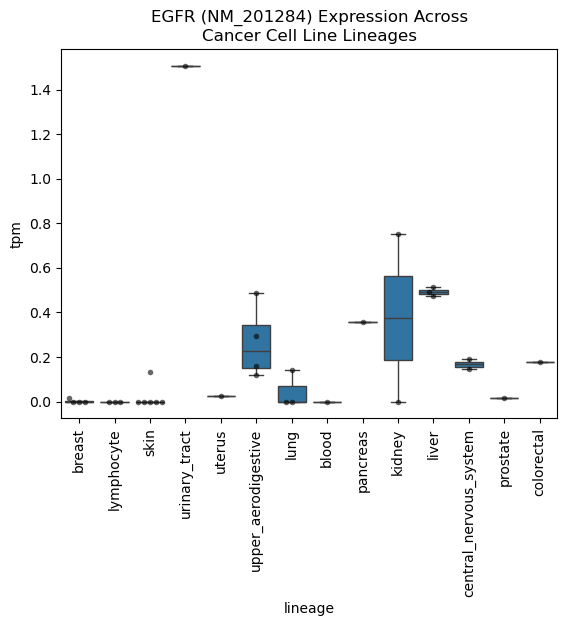

In [45]:
# compare egfr transcript expression across cancer cell types (lineages)
# each point is a cell line
egfr_expression["tpm"] = pd.to_numeric(egfr_expression["tpm"])
ax = sns.boxplot(data=egfr_expression, x='lineage', y='tpm', showfliers=False)
ax = sns.swarmplot(data=egfr_expression, x='lineage', y='tpm', color="black", alpha=0.6, s=4)
plt.xticks(rotation=90)
plt.title("EGFR (NM_201284) Expression Across\nCancer Cell Line Lineages")
plt.show()

## 2.2 How many and which liver cancer cell lines have we sequenced?

- Now that we know which cell lines have the highest EGFR expression, we want to know how many liver cancer cell line models we have profiled

- This information can easily be accessed by performing a simple query

- By looking at the liver cancer cell lines sequenced by bulk RNA-sequencing, we can pick one with desirable properties for use in experiments in the lab

- Keeping track of sequencing cohorts is a non-trivial task & extremely important. 

- Accounting-style questions like this come up all the time, both for internal research questions and for reporting purpurs! Its essential to keep track of how many and which samples an organization has profiled, especially when profiling studies span multiple years and personnal managing projects shift. 

In [61]:
# define query of interest
query_2 = """
SELECT 
    celllinenickname,
    run,
    lineage,
    patientid,
    sex
FROM 
    "userathenadatabase-2htmlbiqyvry"."ccle_raw_data_pkg_metadata" 
WHERE 
    lineage = 'liver';
"""

# execute the query
cursor = conn.cursor()
cursor.execute(query_1)

# fetch the results
liver_cell_lines = pd.read_sql(query_2, conn)
liver_cell_lines

/var/folders/np/3pjq4pjd4gj2x_kjmxbt2wxc0000gn/T/ipykernel_87390/2537690394.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  liver_cell_lines = pd.read_sql(query_2, conn)


,celllinenickname,run,lineage,patientid,sex
0,SNU-886,SRR8615472,liver,SNU886_LIVER,male
1,huH-1,SRR8615664,liver,HUH1_LIVER,male
2,JHH-5,SRR8615920,liver,JHH5_LIVER,male


## 2.3 Which version of `nf-core/rnaseq` pipeline did we run?

- Oh wow! `nf-core` community just released a new version of the rna-seq pipeline with lots of fancy new improvements. Querying pipeline package metadata appended by `nf-quilt` allows us to see which version we used & if we should re-run with the latest version.

- Keeping track of pipeline versions & granular parameters/flags used to run pipelines is crucial to understanding and interpreting datasets! 

- Variation in pipeline methods can have a big impact on results & artificially appear as biological signal in analysis (batch effects!). By being able to quickly query & leverage technical pipeline metadata alongside sample-level metadata & primary data in analysis, computational biologists can fully interpret the patterns they observe to produce high-quality analyses to answer biological questions of interest. 

In [93]:
query_3 = """
SELECT 
    *
FROM 
    "userathenadatabase-2htmlbiqyvry"."quilt-example-bucket_packages-view"
WHERE
    substr(pkg_name, -13) = 'nfcore_rnaseq'
    AND timestamp = 'latest';
"""

# Execute the query
cursor = conn.cursor()
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()

# Read into pandas df
pipeline_metadata = pd.read_sql(query_3, conn)
pipeline_metadata.head()

/var/folders/np/3pjq4pjd4gj2x_kjmxbt2wxc0000gn/T/ipykernel_87390/1916184992.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pipeline_metadata = pd.read_sql(query_3, conn)


,pkg_name,top_hash,timestamp,message,user_meta
0,ccle/20190225_PRJNA523380_nfcore_rnaseq,0d3bb82e640ce25af86a37fa246193b32dab19c9b1e25a...,latest,delete old dirs,"{""quilt"":{""package_id"":""QuiltPackage.quilt_exa..."
1,ccle/20190224_PRJNA523380_nfcore_rnaseq,158cbcd6746a8c663b302943ebfd60d3211c1c11c390be...,latest,nf-quilt:2024-04-02-boring_joliot: nextflow ru...,"{""quilt"":{""package_id"":""QuiltPackage.quilt_exa..."
2,ccle/20190223_PRJNA523380_nfcore_rnaseq,4539bd0e6603db80fa26a29b7a05ccca81bae6c46857b1...,latest,nf-quilt:2024-03-10-trusting_blackwell: nextfl...,"{""quilt"":{""package_id"":""QuiltPackage.quilt_exa..."


In [94]:
# parse metadata to find pipeline version
json.loads(pkg_metadata["user_meta"][0])["workflow"]["manifest"]["values"][0]["version"]

'3.14.0'

In [95]:
# lots of other useful metadata appended by nf-quilt as well
# including all pipeline params
json.loads(pkg_metadata["user_meta"][0])["params"]

{'remove_ribo_rna': False,
 'custom_config_base': 'https://raw.githubusercontent.com/nf-core/configs/master',
 'umi_discard_read': 'null',
 'gencode': False,
 'monochrome-logs': False,
 'plaintext_email': False,
 'validations3pathcheck': False,
 'ribo_database_manifest': '/.nextflow/assets/nf-core/rnaseq/assets/rrna-db-defaults.txt',
 'aligner': 'star_salmon',
 'multiqc_config': 'null',
 'featurecounts_group_type': 'gene_biotype',
 'splicesites': 'null',
 'skip_dupradar': False,
 'validationshowhiddenparams': False,
 'gtf': 's3://ngi-igenomes/igenomes/Homo_sapiens/NCBI/GRCh38/Annotation/Genes/genes.gtf',
 'save_trimmed': False,
 'pseudo_aligner': 'salmon',
 'multiqc_logo': 'null',
 'skip_fastqc': False,
 'deseq2_vst': True,
 'pseudo_aligner_kmer_size': '31',
 'multiqc_methods_description': 'null',
 'umitools_umi_separator': 'null',
 'bam_csi_index': False,
 'with_umi': False,
 'additional_fasta': 'null',
 'skip_qc': False,
 'version': False,
 'publish_dir_mode': 'copy',
 'input': 's3:/